In [1]:
from exp.nb_Tesis import *

In [2]:
min_dim = 128# 448

trainImagesFolderName = f'small_{min_dim}_ISIC_2019_Training_Input'
trainingGroundTruthFileName = 'ISIC_2019_Training_GroundTruth.csv'
testImagesFolderName = 'ISIC2018_Task3_Test_Input'
smallTestImagesFolderName = f'small_{min_dim}_ISIC2018_Task3_Test_Input'

trainingGroundTruthFileName = 'ISIC_2019_Training_GroundTruth.csv'


In [3]:
df = pd.read_csv(trainingGroundTruthFileName); print('# of images: ', len(df)); df.head()

# of images:  25331


,image,MEL,NV,BCC,AK,BKL,DF,VASC,SCC,UNK
0,ISIC_0000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,ISIC_0000001,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,ISIC_0000002,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,ISIC_0000003,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,ISIC_0000004,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
dfSingleLabel = pd.DataFrame({'image':df['image'] })
labelcols = df.columns[1:len(df.columns)]
dfSingleLabel['label'] = df[list(labelcols)].idxmax(axis='columns')
dfSingleLabel.head()

,image,label
0,ISIC_0000000,NV
1,ISIC_0000001,NV
2,ISIC_0000002,MEL
3,ISIC_0000003,NV
4,ISIC_0000004,MEL


In [5]:
#export
labels_for_2018_live_challenge = ['MEL', 'NV', 'BCC', 'AK', 'BKL', 'DF', 'VASC']

def get_label_for_image_name(image_name):
  return list(dfSingleLabel.loc[dfSingleLabel['image']==image_name].label)[0]
  
def get_label_for_image_path(image_path): return get_label_for_image_name(image_path.name[:-4])

#### Prune the dataset if needed

In [6]:
labels_exclusive_for_2019 = ['SCC']
training_for_2018 = True
max_of_each = 30
classDict = {}
images = get_image_files(trainImagesFolderName)
newFolder = f'picked_{max_of_each}_{trainImagesFolderName}'
destFolder = Path(newFolder)
destFolder.mkdir(parents=True, exist_ok=True);

def prune_dataset(image,idx):
    label = get_label_for_image_path(image)
    if training_for_2018 and label in labels_exclusive_for_2019: return
    if label in classDict: classDict[label] = classDict[label] + 1
    else: classDict[label] = 1
    if classDict[label] < max_of_each:
        !cp './'$image $destFolder'/'
#         print(classDict[label],max_of_each)

# parallel(partial(prune_dataset),images)
    

#### Remove warnings

In [7]:
!nvidia-smi

Tue Mar  3 12:20:47 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.87.00    Driver Version: 418.87.00    CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 108...  Off  | 00000000:05:00.0 Off |                  N/A |
| 49%   70C    P2   144W / 250W |   9329MiB / 11177MiB |     90%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX 108...  Off  | 00000000:09:00.0 Off |                  N/A |
|  4%   51C    P2    57W / 250W |  11124MiB / 11178MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
        

In [8]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="torch.nn.functional")

In [12]:
torch.cuda.set_device(0)

## Load the dataset

In [13]:
destFolder

PosixPath('picked_30_small_128_ISIC_2019_Training_Input')

In [95]:
random_seed(1,True)
tfms = get_transforms(flip_vert=True, max_rotate=180,max_zoom=1.8, max_lighting=.3,p_affine=1, max_warp=0)

data = ImageList.from_folder(destFolder)\
.split_by_rand_pct()\
.label_from_func(get_label_for_image_path)\
.transform(tfms,size=128)\
.databunch(bs=16)\
.normalize()

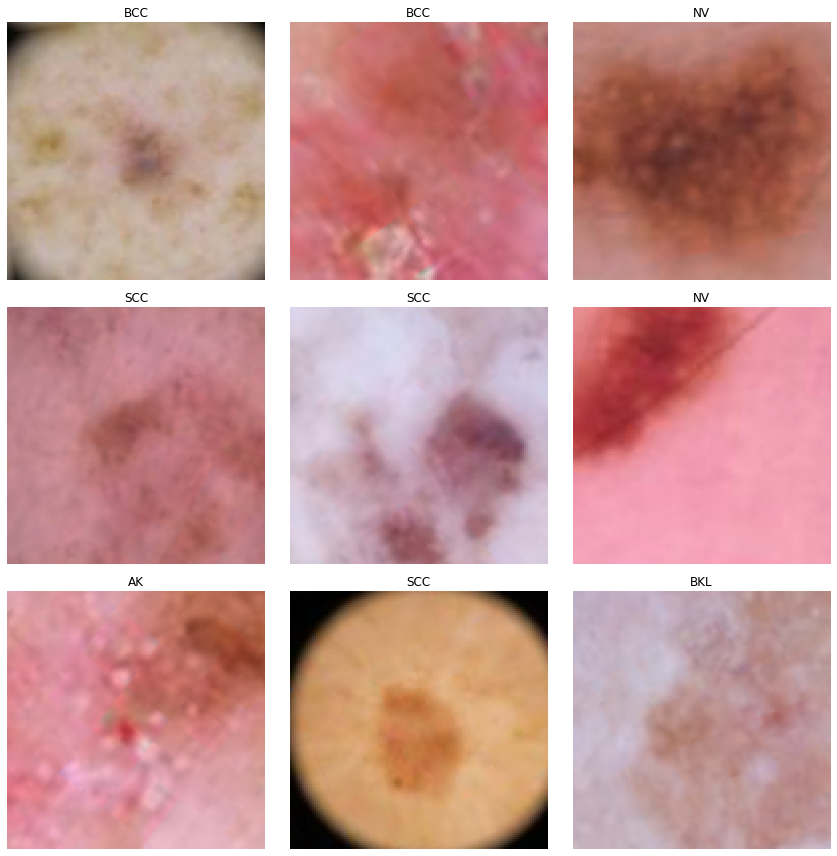

In [97]:
data.show_batch(3)

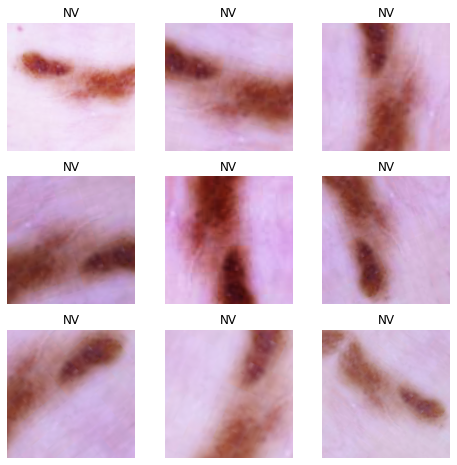

In [96]:
def _plot(i,j,ax):
    x,y = data.train_ds[1]
    x.show(ax, y=y)

plot_multi(_plot, 3, 3, figsize=(8,8))

In [98]:
train_count,valid_count = pd.value_counts(data.train_ds.y.items),pd.value_counts(data.valid_ds.y.items)
train_count.index,valid_count.index = [data.classes[i] for i in train_count.index],[data.classes[i] for i in valid_count.index]

print('train_count: \n',train_count,'\n\n','valid_count: \n', valid_count)
print('ratios:')
print(valid_count / train_count, '%')

train_count: 
 BKL     313
NV      311
AK      305
MEL     300
BCC     297
SCC     278
VASC    196
DF      192
dtype: int64 

 valid_count: 
 BCC     80
AK      80
MEL     78
SCC     70
BKL     69
NV      66
VASC    57
DF      47
dtype: int64
ratios:
AK      0.262295
BCC     0.269360
BKL     0.220447
DF      0.244792
MEL     0.260000
NV      0.212219
SCC     0.251799
VASC    0.290816
dtype: float64 %


In [99]:
#export
def get_class_weights(data):
    train_count,valid_count = pd.value_counts(data.train_ds.y.items),pd.value_counts(data.valid_ds.y.items)
    train_count.index,valid_count.index = [data.classes[i] for i in train_count.index],[data.classes[i] for i in valid_count.index]

    weighted_classes = [{c: (min(train_count) / train_count[c])} for c in data.classes];
    print(weighted_classes)
    formatted_weights = [w[c] for c,w in zip(data.classes, weighted_classes) ]
    class_weights=torch.FloatTensor(formatted_weights).cuda()
    class_weights = class_weights / sum(class_weights)
    return class_weights

def train_learner(learner, name, epochs=8, lr=1e-3, wd = 1e-4, balanced=True):
    if balanced: learner.loss_func = CrossEntropyFlat(weight = get_class_weights(learner.data))
    random_seed(1,True)
    log_name = f'2019_imgsz_{learner.data.valid_ds[0][0].shape[1]}_{name}'
    print("Saving log on: ",log_name)
    learner.fit_one_cycle(epochs,max_lr=lr,wd=wd, callbacks = [
        SaveModelCallback(learn=learner,name=log_name,monitor='accuracy'),
        CSVLogger(learn=learner,filename=log_name)
    #     ReduceLROnPlateauCallback(learn=learn)
    ])

# 1) Experiment: DenseNet201 vs EfficientNet-b0 vs EfficientNet-b3

First let's see the difference between efficientnet and densenet201 all things being equal
Variables:
* Images prerezised to: 128px

* get_transforms(flip_vert=True, max_rotate=180,max_zoom=1.6, max_lighting=.3,p_affine=1, max_warp=0)
* batch_size = 16
* random_seed 1
* epochs = 8 
* one_cycle_policy, max_lr = 1e-3, wd 1e-4
* balancing per class: True
* pretrained = True
* unfreezed = True

train_count: 
 BKL     313
NV      311
AK      305
MEL     300
BCC     297
SCC     278
VASC    196
DF      192
dtype: int64 

 valid_count: 
 BCC     80
AK      80
MEL     78
SCC     70
BKL     69
NV      66
VASC    57
DF      47
dtype: int64

## Efficientnet-b0

In [100]:
from efficientnet_pytorch import EfficientNet

model_name = 'efficientnet-b0'
model_b0 = EfficientNet.from_pretrained(model_name)
model_b0._fc = nn.Linear(1280, data.c) # si es b0 poner aca 1280, si es b3 poner 1536

learn_b0 = Learner(data,model_b0, 
                    metrics=[error_rate,accuracy,AUROC()],
                    callback_fns=[
                            ShowGraph,
                            ActivationStats,
                                ])

# learn_b0.summary()

Loaded pretrained weights for efficientnet-b0


[{'AK': 0.6295081967213115}, {'BCC': 0.6464646464646465}, {'BKL': 0.6134185303514377}, {'DF': 1.0}, {'MEL': 0.64}, {'NV': 0.617363344051447}, {'SCC': 0.6906474820143885}, {'VASC': 0.9795918367346939}]
Saving log on:  2019_imgsz_128_EfficientNet-b0


epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,1.859339,1.678335,0.641682,0.358318,0.578908,01:00
1,1.572454,1.451431,0.563071,0.436929,0.434529,01:13
2,1.479072,1.715216,0.546618,0.453382,0.421146,01:14
3,1.360730,1.313556,0.460695,0.539305,0.389052,01:15
4,1.251834,1.269996,0.462523,0.537477,0.544941,00:58
5,1.107533,1.160414,0.424132,0.575868,0.471788,01:15
6,0.982541,1.079930,0.393053,0.606947,0.424117,01:14
7,0.940236,1.079470,0.394881,0.605119,0.420691,01:01


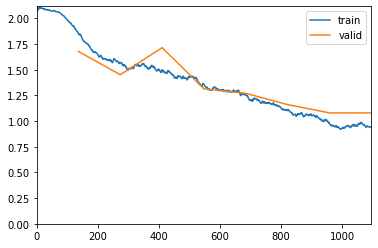

Better model found at epoch 0 with accuracy value: 0.3583180904388428.
Better model found at epoch 1 with accuracy value: 0.4369286894798279.
Better model found at epoch 2 with accuracy value: 0.45338207483291626.
Better model found at epoch 3 with accuracy value: 0.5393053293228149.
Better model found at epoch 5 with accuracy value: 0.5758683681488037.
Better model found at epoch 6 with accuracy value: 0.6069470047950745.


In [101]:
train_learner(learn_b0,'EfficientNet-b0')

## Densenet

In [102]:
dense_learn = cnn_learner(data,models.densenet201, 
                    metrics=[error_rate,accuracy,AUROC()],
                    callback_fns=[
                            ShowGraph,
                            ActivationStats,
                                  ],
                         pretrained=True
                        )

dense_learn.unfreeze()

# dense_learn.summary()

In [103]:
train_learner(dense_learn,'DenseNet-201')

[{'AK': 0.6295081967213115}, {'BCC': 0.6464646464646465}, {'BKL': 0.6134185303514377}, {'DF': 1.0}, {'MEL': 0.64}, {'NV': 0.617363344051447}, {'SCC': 0.6906474820143885}, {'VASC': 0.9795918367346939}]
Saving log on:  2019_imgsz_128_DenseNet-201


epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time


RuntimeError: number of dims don't match in permute

## EfficientNet-b3

In [ ]:
from efficientnet_pytorch import EfficientNet

model_name = 'efficientnet-b3'
model_b3 = EfficientNet.from_pretrained(model_name)
model_b3._fc = nn.Linear(1536, data.c) # si es b0 poner aca 1280, si es b3 poner 1536

learn_b3 = Learner(data,model_b3, 
                    metrics=[error_rate,accuracy,AUROC()],
                    callback_fns=[
                            ShowGraph,
                            ActivationStats,
                                  ]               )

learn_b3.summary()

In [ ]:
train_learner(learn_b3,'EfficientNet-b3')

# Conclusion

* It seems that densenet201 performs worse (higher valid loss) than efficientnet-b0 on 128 sized images.
* Not only it trains slower, but it achieves worse performance. 
* Moreso, EfficientNet-b3 also seems to perform worse than efficientNet-b0. This is counterintuitive and may be due to image size or number of training epochs

# 2) Experiment: Balance or not class weights on EfficientNet-b0

Let's try balancing them

In [260]:
#export
def plot_conf_matrix(interpretation):
    interpretation.plot_confusion_matrix(figsize=(12,12), dpi=60)
    print("Balanced accuracy: ", get_balanced_accurracy(interpretation))
    plt.tight_layout()

def get_balanced_accurracy(interpretation):
    matrix = interpretation.confusion_matrix()
    balanced_acc = 0
    for i in range(len(matrix[0])):
        row = matrix[i]
        correctGuesses = row[i]
        allPossibleTries = row.sum()
        classAcurracy = correctGuesses / allPossibleTries
        balanced_acc += classAcurracy
    balanced_acc /= len(matrix[0])
    return balanced_acc



### Balanced Efficientnet-b0

In [50]:
from efficientnet_pytorch import EfficientNet

model_name = 'efficientnet-b0'
model_b0 = EfficientNet.from_pretrained(model_name)
model_b0._fc = nn.Linear(1280, data.c) # si es b0 poner aca 1280, si es b3 poner 1536

learn_b0 = Learner(data,model_b0, 
                    metrics=[error_rate,accuracy,AUROC()],
                    callback_fns=[
                            ShowGraph,
                            ActivationStats,
                                  ]               )

# learn_b0.summary()

Loaded pretrained weights for efficientnet-b0


EfficientNet
Layer (type)         Output Shape         Param #    Trainable 
ZeroPad2d            [3, 353, 353]        0          False     
______________________________________________________________________
BatchNorm2d          [32, 176, 176]       64         True      
______________________________________________________________________
ZeroPad2d            [32, 178, 178]       0          False     
______________________________________________________________________
BatchNorm2d          [32, 176, 176]       64         True      
______________________________________________________________________
Identity             [32, 1, 1]           0          False     
______________________________________________________________________
Identity             [8, 1, 1]            0          False     
______________________________________________________________________
Identity             [32, 176, 176]       0          False     
_________________________________________________

[{'AK': 1.0307219662058371}, {'BCC': 1.02130898021309}, {'BKL': 1.0}, {'DF': 3.5691489361702127}, {'MEL': 1.0120663650075414}, {'NV': 1.0354938271604939}, {'SCC': 1.3313492063492063}, {'VASC': 3.1800947867298577}]
Saving log on:  2019_imgsz_352_EfficientNet-b0


epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,1.505175,1.806959,0.669847,0.330153,0.679216,01:11
1,1.332565,1.633146,0.562977,0.437023,0.339568,01:11
2,1.007191,0.949778,0.383588,0.616412,0.578001,01:10
3,0.910987,0.876572,0.364504,0.635496,0.580454,01:10


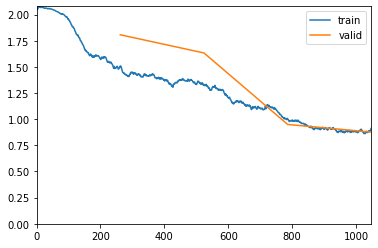

Better model found at epoch 0 with valid_loss value: 1.8069586753845215.
Better model found at epoch 1 with valid_loss value: 1.633145809173584.
Better model found at epoch 2 with valid_loss value: 0.9497779011726379.
Better model found at epoch 3 with valid_loss value: 0.8765718936920166.


In [51]:
train_learner(learn_b0, 'EfficientNet-b0', epochs=4, lr=1e-3)

In [54]:
interp = ClassificationInterpretation.from_learner(learn_b0)

Balanced accuracy:  0.6686269165331498


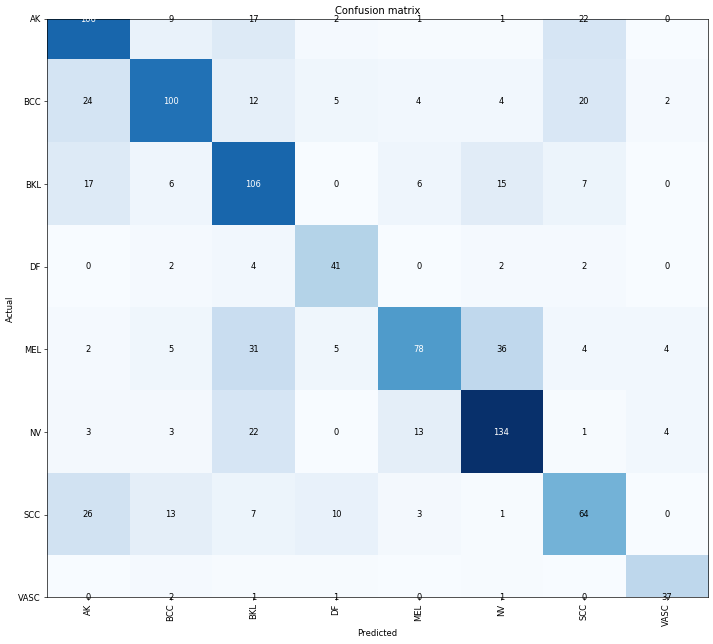

In [55]:
plot_conf_matrix(interp)
plt.tight_layout()

### Unbalanced efficientnet-b0

In [21]:
from efficientnet_pytorch import EfficientNet

model_name = 'efficientnet-b0'
model_b0_unb = EfficientNet.from_pretrained(model_name)
model_b0_unb._fc = nn.Linear(1280, data.c) # si es b0 poner aca 1280, si es b3 poner 1536

learn_b0_unb = Learner(data,model_b0_unb, 
                    metrics=[error_rate,accuracy,AUROC()],
                    callback_fns=[
                            ShowGraph,
                            ActivationStats,
                                  ]               )

# learn_b0_unb.summary()

Loaded pretrained weights for efficientnet-b0


EfficientNet
Layer (type)         Output Shape         Param #    Trainable 
ZeroPad2d            [3, 353, 353]        0          False     
______________________________________________________________________
BatchNorm2d          [32, 176, 176]       64         True      
______________________________________________________________________
ZeroPad2d            [32, 178, 178]       0          False     
______________________________________________________________________
BatchNorm2d          [32, 176, 176]       64         True      
______________________________________________________________________
Identity             [32, 1, 1]           0          False     
______________________________________________________________________
Identity             [8, 1, 1]            0          False     
______________________________________________________________________
Identity             [32, 176, 176]       0          False     
_________________________________________________

Saving log on:  2019_imgsz_352_EfficientNet-b0


epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,1.496898,1.590010,0.577290,0.422710,0.720372,01:10
1,1.325589,1.221184,0.452290,0.547710,0.491775,01:10
2,1.043244,0.970932,0.360687,0.639313,0.546427,01:10
3,0.929495,0.900435,0.327290,0.672710,0.597125,01:10


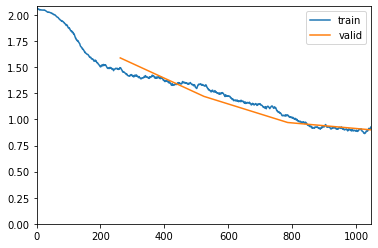

Better model found at epoch 0 with valid_loss value: 1.5900102853775024.
Better model found at epoch 1 with valid_loss value: 1.2211841344833374.
Better model found at epoch 2 with valid_loss value: 0.9709323048591614.
Better model found at epoch 3 with valid_loss value: 0.9004346132278442.


In [22]:
train_learner(learn_b0_unb, 'EfficientNet-b0', epochs=4, lr=1e-3, balanced=False)

In [48]:
interp_unb = ClassificationInterpretation.from_learner(learn_b0_unb)

Balanced accuracy:  0.6913385395384611


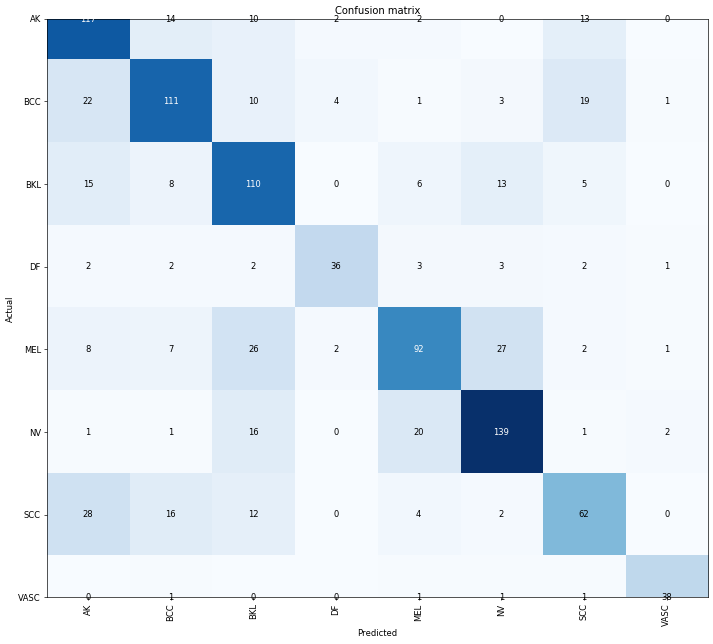

In [49]:
plot_conf_matrix(interp_unb)
plt.tight_layout()

# Conclusion

* Para estas corridas, no balancear por clase parece arrojar la mayor balanced accuracy. Habrá que probar si esto es consistente con corridas con mayor cantidad de epocas. 
* Sin embargo, se puede notar como al balancear por clase aumente la accuracy de la clase DF que es la que se encuentra presente en menor medida en el set de entrenamiento

# 3)  Experiment: Train for longer time EfficientNet-b0 on 700 aprox images of each size 128 vs DenseNet201

In [27]:
from efficientnet_pytorch import EfficientNet

model_name = 'efficientnet-b0'
model_b0_unb = EfficientNet.from_pretrained(model_name)
model_b0_unb._fc = nn.Linear(1280, data.c) # si es b0 poner aca 1280, si es b3 poner 1536

learn_b0_unb = Learner(data,model_b0_unb, 
                    metrics=[error_rate,accuracy,AUROC()],
                    callback_fns=[
                            ShowGraph,
                            ActivationStats,
                                  ]               )

# learn_b0_unb.summary()

Loaded pretrained weights for efficientnet-b0


Saving log on:  2019_imgsz_128_EfficientNet-b0


epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,1.575649,1.829450,0.642789,0.357211,0.579274,00:33
1,1.497026,1.621277,0.577841,0.422159,0.625092,00:32
2,1.343453,1.271714,0.476600,0.523400,0.595318,00:33
3,1.168095,1.102441,0.423114,0.576886,0.606513,00:34
4,1.099712,1.047215,0.409742,0.590258,0.652995,00:33


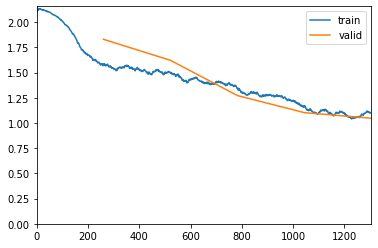

Better model found at epoch 0 with valid_loss value: 1.829450011253357.
Better model found at epoch 1 with valid_loss value: 1.6212773323059082.
Better model found at epoch 2 with valid_loss value: 1.2717138528823853.
Better model found at epoch 3 with valid_loss value: 1.1024410724639893.
Better model found at epoch 4 with valid_loss value: 1.0472149848937988.


In [28]:
train_learner(learn_b0_unb, 'EfficientNet-b0', epochs=5, lr=1e-3, balanced=False)

In [29]:
learn_b0_unb.save('stage1')

Saving log on:  2019_imgsz_128_EfficientNet-b0


epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,0.948231,1.041787,0.412607,0.587393,0.649460,00:33
1,0.802776,1.064946,0.398281,0.601719,0.633751,00:35
2,0.536392,1.109689,0.411652,0.588348,0.566912,00:34
3,0.556551,1.211719,0.415473,0.584527,0.536153,00:33
4,1.032733,1.138344,0.419293,0.580707,0.632792,00:32
5,1.008861,1.065979,0.405922,0.594078,0.617486,00:33
6,0.909966,1.059603,0.408787,0.591213,0.593574,00:33
7,0.948823,1.072382,0.405922,0.594078,0.577591,00:33
8,0.912524,1.064025,0.395415,0.604585,0.569669,00:33
9,0.902373,1.063396,0.398281,0.601719,0.571272,00:33


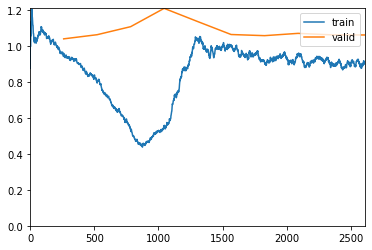

Better model found at epoch 0 with valid_loss value: 1.0417869091033936.


In [30]:
train_learner(learn_b0_unb, 'EfficientNet-b0', epochs=10, wd=1e-06, lr=1e-4, balanced=False)

## Densenet Pretrained

In [13]:
dense_learn = cnn_learner(data,models.densenet201, 
                    metrics=[error_rate,accuracy,AUROC()],
                    callback_fns=[
                            ShowGraph,
                            ActivationStats,
                                  ],
                         pretrained=True)

dense_learn.summary()

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 64, 64]         9,408      False     
______________________________________________________________________
BatchNorm2d          [64, 64, 64]         128        True      
______________________________________________________________________
ReLU                 [64, 64, 64]         0          False     
______________________________________________________________________
MaxPool2d            [64, 32, 32]         0          False     
______________________________________________________________________
BatchNorm2d          [64, 32, 32]         128        True      
______________________________________________________________________
ReLU                 [64, 32, 32]         0          False     
______________________________________________________________________
Conv2d               [128, 32, 32]        8,192      False     
___________________________________________________

Saving log on:  2019_imgsz_128_DenseNet-201


epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,2.443511,2.040746,0.547278,0.452722,0.535582,01:32
1,1.924002,1.664089,0.543458,0.456542,0.536682,01:32
2,1.627639,1.242154,0.444126,0.555874,0.607385,01:32
3,1.412598,1.164053,0.430755,0.569245,0.615319,01:31
4,1.302460,1.155329,0.418338,0.581662,0.616829,01:34


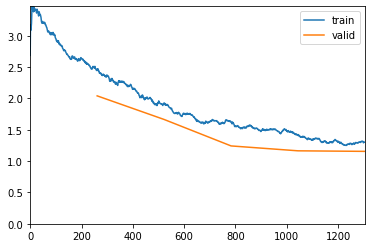

Better model found at epoch 0 with valid_loss value: 2.040745735168457.
Better model found at epoch 1 with valid_loss value: 1.6640890836715698.
Better model found at epoch 2 with valid_loss value: 1.2421543598175049.
Better model found at epoch 3 with valid_loss value: 1.1640533208847046.
Better model found at epoch 4 with valid_loss value: 1.1553287506103516.


In [19]:
train_learner(dense_learn,'DenseNet-201',epochs=5,lr=1e-3,wd=1e-6,balanced=False)

In [15]:
dense_learn.save('dense1')
dense_learn.load('dense1')
dense_learn.unfreeze()

[{'AK': 1.0727848101265822}, {'BCC': 1.0303951367781155}, {'BKL': 1.0}, {'DF': 3.549738219895288}, {'MEL': 1.0303951367781155}, {'NV': 1.036697247706422}, {'SCC': 1.2988505747126438}, {'VASC': 3.4242424242424243}]
Saving log on:  2019_imgsz_128_DenseNet-201


epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,0.949221,1.137313,0.425979,0.574021,0.600905,01:45
1,0.575513,1.113555,0.428844,0.571156,0.638963,01:50
2,0.256064,1.153882,0.423114,0.576886,0.566544,01:45
3,0.441566,1.148843,0.432665,0.567335,0.627171,01:46
4,1.165910,1.170285,0.425024,0.574976,0.585794,01:45
5,1.157173,1.118790,0.443171,0.556829,0.582869,01:43
6,1.065318,1.112273,0.422159,0.577841,0.528808,01:44
7,1.063280,1.068908,0.416428,0.583572,0.538976,01:46
8,1.006625,1.069145,0.425024,0.574976,0.525595,01:46
9,0.964461,1.067861,0.421203,0.578797,0.532691,01:45


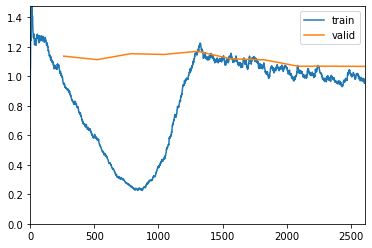

Better model found at epoch 0 with valid_loss value: 1.1373130083084106.
Better model found at epoch 1 with valid_loss value: 1.11355459690094.
Better model found at epoch 6 with valid_loss value: 1.1122734546661377.
Better model found at epoch 7 with valid_loss value: 1.0689079761505127.
Better model found at epoch 9 with valid_loss value: 1.0678611993789673.


In [21]:
train_learner(dense_learn,'DenseNet-201',epochs=10,lr=slice(1e-5,1e-4),wd=1e-6)

# Conclusion

* EfficientNet-b 0alcanza mejor accuracy al final que una densenet201 preentrenada en imagenet.

# 4) Experimento EfficientNet-b2 vs b0 en 700 imagenes aprox de 352px c/u

In [77]:
from efficientnet_pytorch import EfficientNet

model_name = 'efficientnet-b2'
model_b2_unb = EfficientNet.from_pretrained(model_name)
model_b2_unb._fc = nn.Linear(1408, data.c) # si es b0 poner aca 1280, si es b3 poner 1536

learn_b2_unb = Learner(data,model_b2_unb, 
                    metrics=[error_rate,accuracy,AUROC()],
                    callback_fns=[
                            ShowGraph,
                            ActivationStats,
                                  ]               )

learn_b2_unb.summary()

Loaded pretrained weights for efficientnet-b2


EfficientNet
Layer (type)         Output Shape         Param #    Trainable 
ZeroPad2d            [3, 353, 353]        0          False     
______________________________________________________________________
BatchNorm2d          [32, 176, 176]       64         True      
______________________________________________________________________
ZeroPad2d            [32, 178, 178]       0          False     
______________________________________________________________________
BatchNorm2d          [32, 176, 176]       64         True      
______________________________________________________________________
Identity             [32, 1, 1]           0          False     
______________________________________________________________________
Identity             [8, 1, 1]            0          False     
______________________________________________________________________
Identity             [32, 176, 176]       0          False     
_________________________________________________

Saving log on:  2019_imgsz_352_EfficientNet-b2


epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,1.389120,1.521263,0.547129,0.452871,0.506031,01:29
1,1.250517,1.451615,0.541712,0.458288,0.665376,01:29
2,1.126424,0.985157,0.356446,0.643554,0.562447,01:29
3,0.859691,0.890135,0.329361,0.670639,0.551567,01:29
4,0.748306,0.829662,0.305525,0.694475,0.548772,01:29


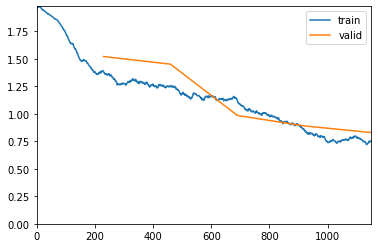

Better model found at epoch 0 with valid_loss value: 1.5212632417678833.
Better model found at epoch 1 with valid_loss value: 1.4516147375106812.
Better model found at epoch 2 with valid_loss value: 0.9851570725440979.
Better model found at epoch 3 with valid_loss value: 0.8901350498199463.
Better model found at epoch 4 with valid_loss value: 0.8296618461608887.


In [78]:
train_learner(learn_b2_unb, 'EfficientNet-b2', epochs=5, lr=1e-3, balanced=False)

In [79]:
learn_b2_unb.save('stage1_b2_unb')

Saving log on:  2019_imgsz_352_EfficientNet-b2


epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,0.672149,0.819479,0.304442,0.695558,0.553438,01:29
1,0.535507,0.819197,0.297942,0.702058,0.548374,01:29
2,0.362463,0.892575,0.306609,0.693391,0.492719,01:29
3,0.308442,0.909055,0.301192,0.698808,0.560519,01:28
4,0.648719,0.861981,0.290358,0.709642,0.561405,01:29
5,0.608516,0.840536,0.289274,0.710726,0.488062,01:29
6,0.580710,0.804272,0.269772,0.730228,0.521411,01:29
7,0.569619,0.786831,0.280607,0.719393,0.500339,01:29
8,0.571163,0.786648,0.275190,0.724810,0.495433,01:29
9,0.517583,0.787352,0.275190,0.724810,0.505129,01:29


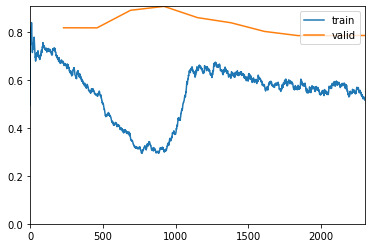

Better model found at epoch 0 with valid_loss value: 0.8194785714149475.
Better model found at epoch 1 with valid_loss value: 0.8191968202590942.
Better model found at epoch 6 with valid_loss value: 0.804272472858429.
Better model found at epoch 7 with valid_loss value: 0.7868306040763855.
Better model found at epoch 8 with valid_loss value: 0.7866480946540833.


In [80]:
train_learner(learn_b2_unb, 'EfficientNet-b2', epochs=10, wd=1e-06, lr=1e-4, balanced=False)

In [143]:
interp_unb = ClassificationInterpretation.from_learner(learn_b2_unb)

Balanced accuracy:  0.7550449645533329


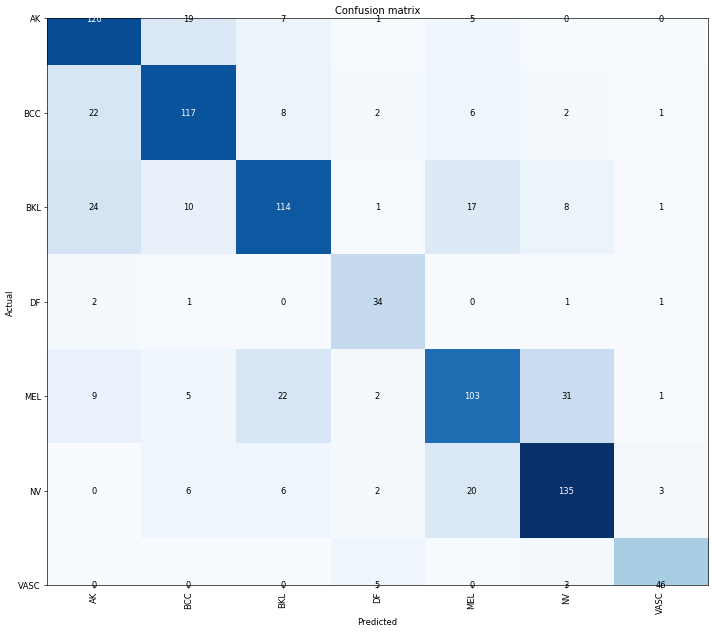

In [144]:
plot_conf_matrix(interp_unb)
plt.tight_layout()

## EfficientNet-b0

In [145]:
from efficientnet_pytorch import EfficientNet

model_name = 'efficientnet-b0'
model_b0_unb = EfficientNet.from_pretrained(model_name)
model_b0_unb._fc = nn.Linear(1280, data.c) # si es b0 poner aca 1280, si es b3 poner 1536

learn_b0_unb = Learner(data,model_b0_unb, 
                    metrics=[error_rate,accuracy,AUROC()],
                    callback_fns=[
                            ShowGraph,
                            ActivationStats,
                                  ]               )

# learn_b0_unb.summary()

Loaded pretrained weights for efficientnet-b0


Saving log on:  2019_imgsz_352_EfficientNet-b0


epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,1.371643,1.742488,0.608884,0.391116,0.470845,01:00
1,1.250212,1.211206,0.457205,0.542795,0.648085,01:01
2,1.081242,0.944097,0.347779,0.652221,0.554009,01:01
3,0.869982,0.884419,0.314193,0.685807,0.612352,01:01
4,0.766856,0.821228,0.293608,0.706392,0.609738,01:01


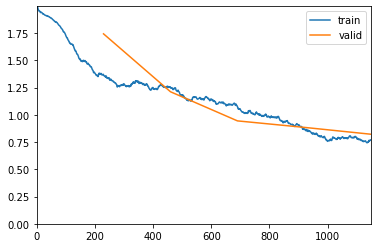

Better model found at epoch 0 with valid_loss value: 1.7424882650375366.
Better model found at epoch 1 with valid_loss value: 1.2112058401107788.
Better model found at epoch 2 with valid_loss value: 0.9440974593162537.
Better model found at epoch 3 with valid_loss value: 0.8844189047813416.
Better model found at epoch 4 with valid_loss value: 0.8212282657623291.


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f3552db0170>
Traceback (most recent call last):
  File "/home/mike/miniconda3/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
  File "/home/mike/miniconda3/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 906, in _shutdown_workers
    w.join()
  File "/home/mike/miniconda3/lib/python3.7/multiprocessing/process.py", line 140, in join
    res = self._popen.wait(timeout)
  File "/home/mike/miniconda3/lib/python3.7/multiprocessing/popen_fork.py", line 48, in wait
    return self.poll(os.WNOHANG if timeout == 0.0 else 0)
  File "/home/mike/miniconda3/lib/python3.7/multiprocessing/popen_fork.py", line 28, in poll
    pid, sts = os.waitpid(self.pid, flag)
KeyboardInterrupt: 


In [146]:
train_learner(learn_b0_unb, 'EfficientNet-b0', epochs=5, lr=1e-3, balanced=False)

In [149]:
learn_b0_unb.save('learn_b0_unb_stage1')

Saving log on:  2019_imgsz_352_EfficientNet-b0


epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,0.682157,0.820194,0.293608,0.706392,0.618143,01:01
1,0.560305,0.831034,0.288191,0.711809,0.626342,01:01
2,0.395581,0.853331,0.291441,0.708559,0.572557,01:01
3,0.366316,0.914014,0.295775,0.704225,0.562480,01:01
4,0.664157,0.830651,0.293608,0.706392,0.577405,01:01
5,0.632061,0.809431,0.279523,0.720477,0.526268,01:01
6,0.622431,0.802045,0.277356,0.722644,0.575288,01:01
7,0.603111,0.778711,0.268689,0.731311,0.541342,01:01
8,0.619321,0.776283,0.270856,0.729144,0.537544,01:01
9,0.565740,0.778176,0.270856,0.729144,0.547299,01:01


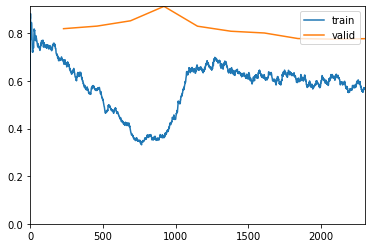

Better model found at epoch 0 with valid_loss value: 0.8201937079429626.
Better model found at epoch 5 with valid_loss value: 0.8094311952590942.
Better model found at epoch 6 with valid_loss value: 0.8020452260971069.
Better model found at epoch 7 with valid_loss value: 0.7787111401557922.
Better model found at epoch 8 with valid_loss value: 0.7762832641601562.


In [150]:
train_learner(learn_b0_unb, 'EfficientNet-b0', epochs=10, wd=1e-06, lr=1e-4, balanced=False)

In [151]:
interp_unb = ClassificationInterpretation.from_learner(learn_b0_unb)


Balanced accuracy:  0.7628818300288894


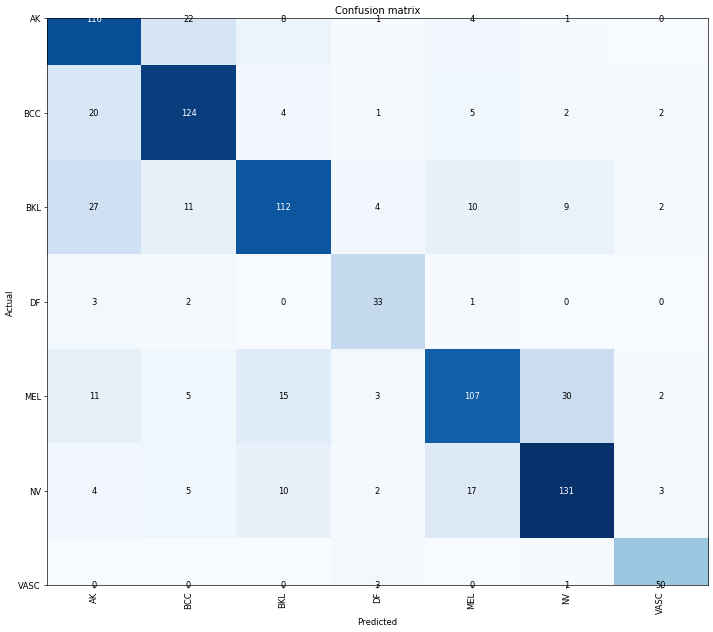

In [152]:

plot_conf_matrix(interp_unb)
plt.tight_layout()

# Conclusion

* EfficientNet-b2 supera a EfficientNet-b0 en 700 imagenes de tamaño 352 px c/u

# 5) EfficientNet-b0 en todas las imagenes 352px

In [177]:
from efficientnet_pytorch import EfficientNet

model_name = 'efficientnet-b0'
model_b0_unb = EfficientNet.from_pretrained(model_name)
model_b0_unb._fc = nn.Linear(1280, data.c) # si es b0 poner aca 1280, si es b3 poner 1536

learn_b0_unb = Learner(data,model_b0_unb, 
                    metrics=[error_rate,accuracy,AUROC()],
                    callback_fns=[
                            ShowGraph,
                            ActivationStats,
                                  ]               )

# learn_b0_unb.summary()

Loaded pretrained weights for efficientnet-b0


[{'AK': 14.96058394160584}, {'BCC': 3.838202247191011}, {'BKL': 4.882324916626965}, {'DF': 53.09844559585492}, {'MEL': 2.7977067977067978}, {'NV': 1.0}, {'VASC': 49.990243902439026}]
Saving log on:  2019_imgsz_352_EfficientNet-b0


epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,1.449680,1.619935,0.513360,0.486640,0.413517,05:21
1,1.259779,1.378782,0.521862,0.478138,0.317683,05:21
2,1.120220,1.237220,0.498583,0.501417,0.721190,05:20
3,0.915015,0.881475,0.330769,0.669231,0.689812,05:21
4,0.855178,0.806439,0.306680,0.693320,0.638419,05:20


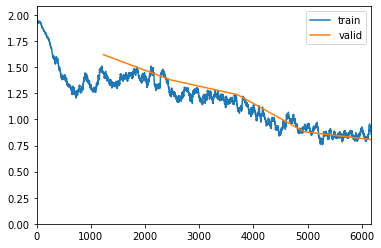

Better model found at epoch 0 with valid_loss value: 1.6199352741241455.
Better model found at epoch 1 with valid_loss value: 1.3787816762924194.
Better model found at epoch 2 with valid_loss value: 1.2372199296951294.
Better model found at epoch 3 with valid_loss value: 0.8814748525619507.
Better model found at epoch 4 with valid_loss value: 0.8064386248588562.


In [178]:
train_learner(learn_b0_unb, 'EfficientNet-b0', epochs=5, lr=1e-3, balanced=True)

In [179]:
learn_b0_unb.save('learn_b0_unb_stage1')

In [181]:
learn_b0_unb.load('learn_b0_unb_stage1')

Learner(data=ImageDataBunch;

Train: LabelList (19763 items)
x: ImageList
Image (3, 352, 352),Image (3, 352, 352),Image (3, 352, 352),Image (3, 352, 352),Image (3, 352, 352)
y: CategoryList
MEL,NV,NV,NV,MEL
Path: picked_100000_small_352_ISIC_2019_Training_Input;

Valid: LabelList (4940 items)
x: ImageList
Image (3, 352, 352),Image (3, 352, 352),Image (3, 352, 352),Image (3, 352, 352),Image (3, 352, 352)
y: CategoryList
NV,NV,NV,BKL,BKL
Path: picked_100000_small_352_ISIC_2019_Training_Input;

Test: None, model=EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
  )
  (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
        (static_padding): Z

[{'AK': 14.96058394160584}, {'BCC': 3.838202247191011}, {'BKL': 4.882324916626965}, {'DF': 53.09844559585492}, {'MEL': 2.7977067977067978}, {'NV': 1.0}, {'VASC': 49.990243902439026}]
Saving log on:  2019_imgsz_352_EfficientNet-b0


epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,0.917255,0.803911,0.313158,0.686842,0.665072,05:21
1,0.715551,0.794354,0.275911,0.724089,0.604830,05:20
2,0.606250,0.814558,0.284008,0.715992,0.521700,05:20
3,0.638637,0.814158,0.270243,0.729757,0.548444,05:20
4,0.784642,0.747966,0.292510,0.707490,0.724676,05:20
5,0.748091,0.749497,0.296761,0.703239,0.566950,05:19
6,0.637441,0.728860,0.270445,0.729555,0.553820,05:20
7,0.668888,0.718326,0.268623,0.731377,0.522627,05:21
8,0.701841,0.712900,0.272470,0.727530,0.524249,05:22
9,0.730545,0.713974,0.275304,0.724696,0.524157,05:22


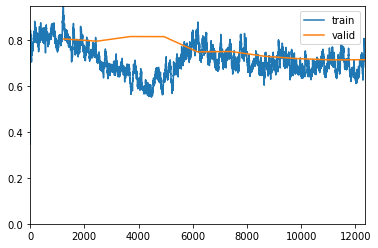

Better model found at epoch 0 with valid_loss value: 0.8039112091064453.
Better model found at epoch 1 with valid_loss value: 0.7943538427352905.
Better model found at epoch 4 with valid_loss value: 0.7479661107063293.
Better model found at epoch 6 with valid_loss value: 0.7288597226142883.
Better model found at epoch 7 with valid_loss value: 0.7183264493942261.
Better model found at epoch 8 with valid_loss value: 0.7128997445106506.


In [182]:
train_learner(learn_b0_unb, 'EfficientNet-b0', epochs=10, wd=1e-06, lr=1e-4, balanced=True)

[{'AK': 14.96058394160584}, {'BCC': 3.838202247191011}, {'BKL': 4.882324916626965}, {'DF': 53.09844559585492}, {'MEL': 2.7977067977067978}, {'NV': 1.0}, {'VASC': 49.990243902439026}]
Saving log on:  2019_imgsz_352_EfficientNet-b0


epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,0.676858,0.716054,0.273887,0.726113,0.522631,05:20
1,0.558300,0.717161,0.266397,0.733603,0.509106,05:21
2,0.475479,0.731136,0.255061,0.744939,0.439210,05:19
3,0.491391,0.746610,0.257490,0.742510,0.401335,05:22
4,0.600645,0.734281,0.262146,0.737854,0.413396,05:23
5,0.585451,0.730879,0.260526,0.739474,0.434011,05:22
6,0.552486,0.726130,0.258907,0.741093,0.440610,05:22
7,0.619592,0.725811,0.261134,0.738866,0.438411,05:22
8,0.680042,0.722421,0.261538,0.738462,0.445304,05:22
9,0.737701,0.725239,0.262753,0.737247,0.448024,05:22


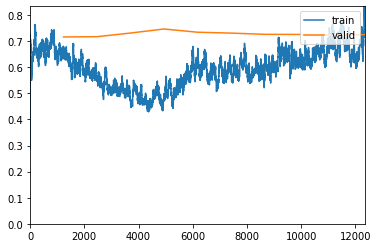

Better model found at epoch 0 with valid_loss value: 0.7160537838935852.


In [183]:
train_learner(learn_b0_unb, 'EfficientNet-b0', epochs=10, wd=1e-07, lr=1e-5, balanced=True)

In [184]:
learn_b0_unb.save('final training')

# Conclusion

Dio .743 en ISIC. Parece valer más la pena no usar todas las imagenes. Tal vez solo 700

# Test

In [258]:
#export
def test_learner(learner,name,test_images_folder): 
    learn_b2_unb.export(f'{name}.pkl')
    learn_test = load_learner(path=learner.path, file=f'{export_name}.pkl', 
                     test=ImageList.from_folder(test_images_folder),
                     )

    preds, y = learn_test.TTA(ds_type=DatasetType.Test, beta=0.4, scale=1.35)

    cols = ['image'] + learn2.data.classes


    predictions = []
    for idx, filePath in enumerate(learn2.data.test_ds.items):
        row = {}
        current_pred = preds[idx]
        row['image'] = filePath.name.replace('.jpg','')
        for idx2, cat in enumerate(learn_test.data.classes):
            row[cat] = current_pred[idx2].item()

        predictions.append(row)

    predictionsDf = pd.DataFrame(predictions, columns=cols);



    print(len(predictionsDf))
    predictionsDf = predictionsDf.rename(columns={'AK':'AKIEC'})
    # predictionsDf2 = predictionsDf.drop(columns=['SCC'])
    predictionsDf.head()
    predictions_csv_path = f'{name}.csv'
    predictionsDf.to_csv(predictions_csv_path, index=False)
    return predictions_csv_path

In [256]:
test_learner(learn_b2_unb, 'learn_b2_unb', test_folder=smallTestImagesFolderName)

1512


'learn_b2_unb.csv'